In [ ]:
!pip install soundata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.0/162.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 21.1 MB/s eta 0:00:00
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64901 sha256=995208cca29ee7adf30b58d664fca154ae9fb250951156d5

In [ ]:
import soundata

dataset = soundata.initialize('urbansound8k')
dataset.download()  # download the dataset
dataset.validate()  # validate that all the expected files are there

example_clip = dataset.choice_clip()  # choose a random example clip
print(example_clip)  # see the available data

100%|██████████| 8732/8732 [00:59<00:00, 147.74it/s]

Clip(
  audio_path="/root/sound_datasets/urbansound8k/audio/fold6/159702-6-3-0.wav",
  clip_id="159702-6-3-0",
  audio: The clip's audio
            * np.ndarray - audio signal
            * float - sample rate,
  class_id: The clip's class id.
            * int - integer representation of the class label (0-9). See Dataset Info in the documentation for mapping,
  class_label: The clip's class label.
            * str - string class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music,
  fold: The clip's fold.
            * int - fold number (1-10) to which this clip is allocated. Use these folds for cross validation,
  freesound_end_time: The clip's end time in Freesound.
            * float - end time in seconds of the clip in the original freesound recording,
  freesound_id: The clip's Freesound ID.
            * str - ID of the freesound.org recording from which this clip was taken,
  freesound_start_time: T

In [ ]:
print("Total # of clips:  "+ str(len(dataset.clip_ids)))
clip_tmp = 10
dataset.clip(dataset.clip_ids[clip_tmp]).audio

Total # of clips:  8732


(array([-3.1082153e-02, -3.1112671e-02, -3.0868530e-02, ...,
        -6.8664551e-04,  6.1035156e-05,  3.2043457e-04], dtype=float32),
 44100)

In [ ]:
!pip install librosa
# !pip install --upgrade huggingface-hub

In [ ]:
# Feature extraction example
import numpy as np
import librosa

# Load the example clip
y, sr = dataset.clip(dataset.clip_ids[clip_tmp]).audio

# Set the hop length; at 44100 Hz, 512 samples ~= 46ms
hop_length = 512

# Separate harmonics and percussives into two waveforms
y_harmonic, y_percussive = librosa.effects.hpss(y)

# Beat track on the percussive signal
tempo, beat_frames = librosa.beat.beat_track(y=y_percussive,
                                             sr=sr)

# Compute MFCC features from the raw signal
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)

# And the first-order differences (delta features)
mfcc_delta = librosa.feature.delta(mfcc)

# Stack and synchronize between beat events
# This time, we'll use the mean value (default) instead of median
beat_mfcc_delta = librosa.util.sync(np.vstack([mfcc, mfcc_delta]),
                                    beat_frames)

# Compute chroma features from the harmonic signal
chromagram = librosa.feature.chroma_cqt(y=y_harmonic,
                                        sr=sr)

# Aggregate chroma features between beat events
# We'll use the median value of each feature between beat frames
beat_chroma = librosa.util.sync(chromagram,
                                beat_frames,
                                aggregate=np.median)

# Finally, stack all beat-synchronous features together
beat_features = np.vstack([beat_chroma, beat_mfcc_delta])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

import librosa
# Load the example clip
y, sr = dataset.clip(dataset.clip_ids[clip_tmp]).audio

# And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))

353625

In [ ]:
S_full.shape

(1025, 345)

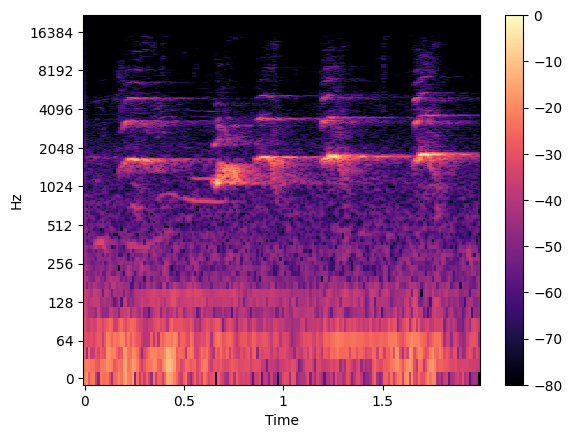

In [ ]:
idx = slice(*librosa.time_to_frames([0, 2], sr=sr))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

In [ ]:
Audio(data=y[0*sr:2*sr], rate=sr)